Imports

In [1]:
import random
import operator

import numpy as np
import matplotlib.pyplot as plt

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

Create classes

In [2]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,-1.0))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

Primitives and toolbox

In [3]:
random.seed(0)

def identity(x):
    return x

pset = gp.PrimitiveSetTyped("MAIN", in_types=[float, float, float, float, float, float, float], ret_type=bool)
pset.addPrimitive(np.less, in_types=[float, float], ret_type=bool)
pset.addPrimitive(np.greater, in_types=[float, float], ret_type=bool)
pset.addPrimitive(np.equal, in_types=[float, float], ret_type=bool)
pset.addPrimitive(np.logical_not, in_types=[bool], ret_type=bool)
pset.addPrimitive(np.logical_and, in_types=[bool, bool], ret_type=bool)
pset.addPrimitive(np.logical_or, in_types=[bool, bool], ret_type=bool)
pset.addPrimitive(identity, in_types=[float], ret_type=float)
pset.addEphemeralConstant("float_const", ephemeral=lambda: random.randint(0, 100), ret_type=float)
pset.addEphemeralConstant("bool_const", ephemeral=lambda: random.randint(0, 1), ret_type=bool)

pset.renameArguments(ARG0="Pclass")
pset.renameArguments(ARG1="Sex")
pset.renameArguments(ARG2="Age")
pset.renameArguments(ARG3="SibSp")
pset.renameArguments(ARG4="Parch")
pset.renameArguments(ARG5="Fare")
pset.renameArguments(ARG6="Embarked")

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

Data

In [4]:
# Load data into numpy array (numeric data only)
sex = lambda x: 0.0 if x == b"male" else 1.0  # male = 0, female = 1
embarked = lambda x: 0.0 if x == b'C' else 2.0 if x == b'Q' else 1.0 # C = 0, S = 1, Q = 2; fill missing embarked values with S
data = np.genfromtxt(open("../data/train.csv"), delimiter=',', skip_header=1, usecols=(1, 2, 5, 6, 7, 8, 10, 12), converters={5: sex, 12: embarked})

# Fill missing age and fare (testing data only) values with averages for each class
def fill_missing(data):
    class1 = data[:, 0] == 1
    class2 = data[:, 0] == 2
    class3 = data[:, 0] == 3

    avg_age1 = np.nanmean(data[class1, 2])
    avg_age2 = np.nanmean(data[class2, 2])
    avg_age3 = np.nanmean(data[class3, 2])
    avg_fare1 = np.nanmean(data[class1, 5])
    avg_fare2 = np.nanmean(data[class2, 5])
    avg_fare3 = np.nanmean(data[class3, 5])

    age_nans = np.isnan(data[:, 2])
    fare_nans = np.isnan(data[:, 5])

    data[age_nans & class1, 2] = avg_age1
    data[age_nans & class2, 2] = avg_age2
    data[age_nans & class3, 2] = avg_age3
    data[fare_nans & class1, 5] = avg_fare1
    data[fare_nans & class2, 5] = avg_fare2
    data[fare_nans & class3, 5] = avg_fare3

X = data[:, 1:]
y = data[:, 0]
fill_missing(X)

Evaluation Function

In [5]:
def evalClassif(individual, examples, labels, pset):
    func = gp.compile(expr=individual, pset=pset)
    preds = func(*examples.T)

    return (np.sum((preds == 1) & (labels == 0)), np.sum((preds == 0) & (labels == 1)))

toolbox.register("evaluate", evalClassif, examples=X, labels=y, pset=pset)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

Main Algorithm

In [6]:
NGEN = 250
MU = 500
LAMBDA = 1000
CXPB = 0.2
MUTPB = 0.5

# Wrapper for AUC calculation per generation
class ParetoFrontAUC(tools.ParetoFront):
    def __init__(self):
        super().__init__()
        self.aucs = []
    
    def update(self, pop):
        super().update(pop)
        fitness_1 = [ind.fitness.values[0] for ind in self]
        fitness_2 = [ind.fitness.values[1] for ind in self]
        auc = np.sum(np.abs(np.diff(fitness_1))*fitness_2[:-1])
        self.aucs.append(auc)

pop = toolbox.population(n=MU)
hof = ParetoFrontAUC()
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean, axis=0)
stats.register("std", np.std, axis=0)
stats.register("min", np.min, axis=0)
stats.register("max", np.max, axis=0)

pop, logbook = algorithms.eaMuPlusLambda(pop, toolbox, MU, LAMBDA, CXPB, MUTPB, NGEN, stats,
                          halloffame=hof)

gen	nevals	avg              	std                        	min    	max        
0  	500   	[218.846 205.29 ]	[253.4849942  152.25367615]	[0. 0.]	[549. 342.]
1  	689   	[ 31.754 320.89 ]	[114.35464785  67.64618171]	[0. 0.]	[549. 342.]
2  	697   	[1.88000e-01 3.41284e+02]	[2.5939653  3.67577801]    	[  0. 264.]	[ 54. 342.]
3  	719   	[3.40000e-02 3.41094e+02]	[0.46135019 1.34505167]    	[  0. 335.]	[  7. 342.]
4  	692   	[2.28000e-01 3.40124e+02]	[4.96064673 5.54045341]    	[  0. 251.]	[111. 342.]
5  	695   	[2.14000e-01 3.39618e+02]	[4.64803227 7.42752152]    	[  0. 177.]	[104. 342.]
6  	701   	[  1.098 338.808]        	[19.2342506   8.95405696]  	[  0. 171.]	[411. 342.]
7  	735   	[1.82000e-01 3.38564e+02]	[2.1589062  7.01554731]    	[  0. 189.]	[ 41. 342.]
8  	673   	[  1.256 337.5  ]        	[24.60240769 16.57292973]  	[0. 0.]    	[549. 342.]
9  	712   	[  0.882 337.94 ]        	[17.48942755  7.54562125]  	[  0. 172.]	[391. 342.]
10 	696   	[  0.512 337.61 ]        	[ 7.40201702 10.6870

92 	729   	[3.00000e-02 3.35528e+02]	[0.62697687 1.81251648]    	[  0. 332.]	[ 14. 342.]
93 	695   	[3.60000e-02 3.35406e+02]	[0.6501569  1.57770846]    	[  0. 335.]	[ 14. 342.]
94 	711   	[2.38000e-01 3.34972e+02]	[4.66619288 7.19216351]    	[  0. 177.]	[104. 342.]
95 	717   	[  0.95  334.924]        	[19.8939061  10.23280138]  	[  0. 109.]	[445. 342.]
96 	716   	[  0.346 335.068]        	[4.78563308 5.69380154]    	[  0. 249.]	[ 75. 342.]
97 	704   	[1.66000e-01 3.35318e+02]	[3.36488395 4.23755543]    	[  0. 249.]	[ 75. 342.]
98 	702   	[  0.586 334.684]        	[ 7.28797667 10.34176697]  	[  0. 177.]	[104. 342.]
99 	706   	[7.60000e-02 3.35092e+02]	[1.65354891 6.00529233]    	[  0. 205.]	[ 37. 342.]
100	714   	[8.00000e-03 3.35328e+02]	[0.1411949  1.37565112]    	[  0. 332.]	[  3. 342.]
101	712   	[2.34000e-01 3.35346e+02]	[1.74334277 2.03231002]    	[  0. 308.]	[ 16. 342.]
102	702   	[  1.146 334.674]        	[24.00243079 15.01358465]  	[0. 1.]    	[537. 342.]
103	724   	[  0.994 3

186	705   	[  0.364 312.13 ]        	[5.67727963 9.44293916]    	[  0. 251.]	[111. 342.]
187	710   	[2.56000e-01 3.11612e+02]	[4.9934421 8.1403597]      	[  0. 251.]	[111. 342.]
188	699   	[1.40000e-02 3.11422e+02]	[0.17263835 8.15793577]    	[  0. 251.]	[  3. 342.]
189	700   	[2.20000e-02 3.11792e+02]	[0.44890534 7.35341662]    	[  0. 279.]	[ 10. 342.]
190	693   	[3.00000e-02 3.10736e+02]	[0.28478062 8.88404773]    	[  0. 251.]	[  3. 342.]
191	700   	[2.0000e-03 3.1217e+02]  	[0.04467662 8.04842221]    	[  0. 279.]	[  1. 342.]
192	700   	[6.40000e-02 3.11988e+02]	[1.21651305 8.86475358]    	[  0. 251.]	[ 27. 342.]
193	701   	[1.20000e-02 3.11742e+02]	[0.18935681 7.61547346]    	[  0. 251.]	[  3. 342.]
194	687   	[4.00000e-02 3.11598e+02]	[0.50438081 9.08055042]    	[  0. 251.]	[ 10. 342.]
195	710   	[5.60000e-02 3.12096e+02]	[1.20700621 8.07779574]    	[  0. 279.]	[ 27. 342.]
196	682   	[4.00000e-03 3.11308e+02]	[0.06311894 6.57975197]    	[  0. 279.]	[  1. 342.]
197	727   	[1.34000e-

Best individual is: logical_and(greater(Fare, Age), greater(Sex, identity(identity(Parch))))
with fitness: (0.0, 279.0)


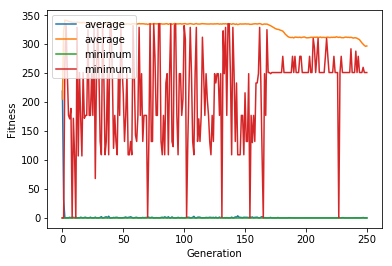

In [7]:
print("Best individual is: %s\nwith fitness: %s" % (hof[0], hof[0].fitness))
gen, avg, min_, max_ = logbook.select("gen", "avg", "min", "max")
plt.plot(gen, avg, label="average")
plt.plot(gen, min_, label="minimum")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(loc="upper left")
plt.show()

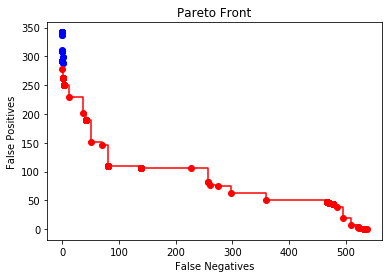

Area Under Curve: 48862.0


In [8]:
"""Split fitness values into separate lists"""
fitness_1 = [ind.fitness.values[0] for ind in hof]
fitness_2 = [ind.fitness.values[1] for ind in hof]
pop_1 = [ind.fitness.values[0] for ind in pop]
pop_2 = [ind.fitness.values[1] for ind in pop]

'''Print dominated population for debugging'''
# for ind in pop:
#     print(ind.fitness)

plt.scatter(pop_1, pop_2, color='b')
plt.scatter(fitness_1, fitness_2, color='r')
plt.plot(fitness_1, fitness_2, color='r', drawstyle='steps-post')
plt.xlabel("False Negatives")
plt.ylabel("False Positives")
plt.title("Pareto Front")
plt.show()

f1 = np.array(fitness_1)
f2 = np.array(fitness_2)

"""Calculate area under curve with least squares method"""
print("Area Under Curve: %s" % (np.sum(np.abs(np.diff(f1))*f2[:-1])))

AUC Graph

In [9]:
random.seed(0)

creator.create("FitnessMin2", base.Fitness, weights=(-1.0,-1.0))
creator.create("Individual2", gp.PrimitiveTree, fitness=creator.FitnessMin2)

def identity(x):
    return x

pset = gp.PrimitiveSetTyped("MAIN", in_types=[float, float, float, float, float, float, float], ret_type=bool)
pset.addPrimitive(np.less, in_types=[float, float], ret_type=bool)
pset.addPrimitive(np.greater, in_types=[float, float], ret_type=bool)
pset.addPrimitive(np.equal, in_types=[float, float], ret_type=bool)
pset.addPrimitive(np.logical_not, in_types=[bool], ret_type=bool)
pset.addPrimitive(np.logical_and, in_types=[bool, bool], ret_type=bool)
pset.addPrimitive(np.logical_or, in_types=[bool, bool], ret_type=bool)
pset.addPrimitive(identity, in_types=[float], ret_type=float)

pset.addPrimitive(operator.xor, [bool, bool], bool)
pset.addPrimitive(operator.mul, [float, float], float)
pset.addPrimitive(operator.add, [float, float], float)
pset.addPrimitive(operator.sub, [float, float], float)

pset.addEphemeralConstant("float_const2", ephemeral=lambda: random.randint(0, 100), ret_type=float)
pset.addEphemeralConstant("bool_const2", ephemeral=lambda: random.randint(0, 1), ret_type=bool)

pset.renameArguments(ARG0="Pclass")
pset.renameArguments(ARG1="Sex")
pset.renameArguments(ARG2="Age")
pset.renameArguments(ARG3="SibSp")
pset.renameArguments(ARG4="Parch")
pset.renameArguments(ARG5="Fare")
pset.renameArguments(ARG6="Embarked")

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual2, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

def evalClassif(individual, examples, labels, pset):
    func = gp.compile(expr=individual, pset=pset)
    preds = func(*examples.T)

    return (np.sum((preds == 1) & (labels == 0)), np.sum((preds == 0) & (labels == 1)))

toolbox.register("evaluate", evalClassif, examples=X, labels=y, pset=pset)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))



NGEN = 250
MU = 600
LAMBDA = 1500
CXPB = 0.3
MUTPB = 0.6

pop = toolbox.population(n=MU)
hof2 = ParetoFrontAUC()
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean, axis=0)
stats.register("std", np.std, axis=0)
stats.register("min", np.min, axis=0)
stats.register("max", np.max, axis=0)

pop, logbook = algorithms.eaMuPlusLambda(pop, toolbox, MU, LAMBDA, CXPB, MUTPB, NGEN, stats,
                          halloffame=hof2)

gen	nevals	avg                        	std                        	min    	max        
0  	600   	[224.53166667 201.83666667]	[256.67161705 154.63350216]	[0. 0.]	[549. 342.]
1  	1363  	[ 41.64       311.79666667]	[129.81078692  80.83084388]	[0. 0.]	[549. 342.]
2  	1364  	[  3.40166667 338.97833333]	[36.54317534 24.29391962]  	[0. 0.]	[549. 342.]
3  	1343  	[  4.335      338.32833333]	[44.07303909 27.4950395 ]  	[0. 0.]	[549. 342.]
4  	1338  	[  2.06833333 339.18      ]	[30.89488087 20.42255942]  	[0. 0.]	[549. 342.]
5  	1368  	[1.73333333e-01 3.40396667e+02]	[3.11393998 5.10124059]    	[  0. 249.]	[ 75. 342.]
6  	1336  	[1.01666667e-01 3.39970000e+02]	[1.37888743 3.87759805]    	[  0. 278.]	[ 24. 342.]
7  	1347  	[  0.41166667 338.995     ]    	[5.12629144 8.27214049]    	[  0. 205.]	[ 97. 342.]
8  	1352  	[  1.715 337.87 ]              	[28.80619913 15.95795831]  	[0. 0.]    	[549. 342.]
9  	1352  	[1.41666667e-01 3.37906667e+02]	[1.40532222 3.29867987]    	[  0. 310.]	[ 26. 342.]
10 

86 	1337  	[  0.49833333 266.59833333]    	[ 3.8065729  22.67275157]  	[  0. 164.]	[ 47. 342.]
87 	1352  	[  0.275 267.155]              	[ 2.7299649  22.63767453]  	[  0. 164.]	[ 47. 342.]
88 	1375  	[  0.41666667 265.59666667]    	[ 3.23363401 23.54755448]  	[  0. 178.]	[ 40. 342.]
89 	1363  	[  0.85166667 263.36166667]    	[16.87788486 21.40009807]  	[  0. 188.]	[411. 342.]
90 	1365  	[  0.50833333 261.46      ]    	[ 4.34548776 21.750059  ]  	[  0. 181.]	[ 62. 342.]
91 	1349  	[  1.095      260.38166667]    	[19.21117665 24.94532683]  	[ 0. 51.]  	[467. 342.]
92 	1350  	[  0.395 257.725]              	[ 3.21231614 22.94186947]  	[  0. 165.]	[ 46. 342.]
93 	1345  	[2.33333333e-01 2.56745000e+02]	[ 2.59850384 22.78676462]  	[  0. 168.]	[ 45. 342.]
94 	1340  	[  0.315 257.02 ]              	[ 3.55936909 25.08092768]  	[  0. 166.]	[ 69. 342.]
95 	1374  	[  0.58833333 255.51666667]    	[ 4.44134333 24.73781967]  	[  0. 162.]	[ 62. 342.]
96 	1363  	[  0.875 256.12 ]              	[11.107

173	1349  	[9.66666667e-02 2.43380000e+02]	[ 1.54401713 15.68732822]  	[  0. 181.]	[ 36. 342.]
174	1351  	[2.83333333e-02 2.43376667e+02]	[ 0.30691566 15.42243352]  	[  0. 236.]	[  5. 342.]
175	1353  	[1.33333333e-01 2.42935000e+02]	[ 1.88119347 15.20528773]  	[  0. 150.]	[ 41. 342.]
176	1355  	[  0.39166667 242.425     ]    	[ 4.90254327 14.25065057]  	[  0. 185.]	[ 93. 342.]
177	1354  	[2.31666667e-01 2.43803333e+02]	[ 2.28210368 17.31371293]  	[  0. 165.]	[ 46. 342.]
178	1337  	[  0.34  243.325]              	[ 3.04320007 16.82724106]  	[  0. 164.]	[ 46. 342.]
179	1360  	[1.01666667e-01 2.43871667e+02]	[ 0.98217304 15.90320294]  	[  0. 195.]	[ 17. 342.]
180	1358  	[1.30000000e-01 2.42531667e+02]	[ 1.21782593 13.05956854]  	[  0. 194.]	[ 16. 342.]
181	1355  	[1.00000000e-01 2.44808333e+02]	[ 1.106044   18.13481726]  	[  0. 227.]	[ 18. 342.]
182	1373  	[  0.41       243.60666667]    	[ 4.93577755 16.65168527]  	[  0. 160.]	[100. 342.]
183	1386  	[  0.28833333 244.03666667]    	[ 2.818

plot modified

Best individual is: greater(identity(Embarked), add(sub(Age, identity(sub(mul(mul(Parch, mul(sub(Pclass, Embarked), identity(Parch))), Parch), identity(add(add(sub(SibSp, mul(Embarked, identity(add(Embarked, add(sub(SibSp, Sex), Sex))))), sub(Age, Age)), sub(add(mul(Age, Pclass), mul(identity(add(Sex, add(identity(add(Sex, SibSp)), sub(add(mul(Age, Embarked), mul(SibSp, Sex)), Age)))), sub(SibSp, identity(SibSp)))), add(Parch, Pclass))))))), mul(identity(add(identity(mul(Embarked, Parch)), add(sub(identity(identity(sub(identity(SibSp), identity(SibSp)))), Sex), sub(Age, Age)))), add(add(Age, identity(add(add(mul(Age, Embarked), mul(SibSp, mul(SibSp, Embarked))), add(sub(SibSp, mul(Parch, Pclass)), sub(Age, Age))))), mul(Fare, Sex)))))
with fitness: (0.0, 236.0)


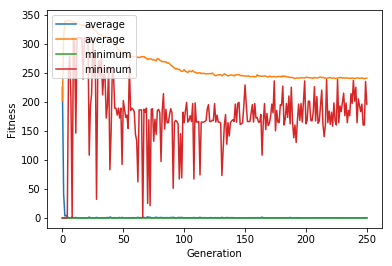

In [10]:
print("Best individual is: %s\nwith fitness: %s" % (hof2[0], hof2[0].fitness))
gen, avg, min_, max_ = logbook.select("gen", "avg", "min", "max")
plt.plot(gen, avg, label="average")
plt.plot(gen, min_, label="minimum")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(loc="upper left")
plt.show()

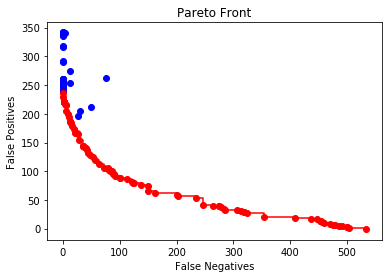

Area Under Curve: 29589.0


In [11]:
"""Split fitness values into separate lists"""
fitness_1 = [ind.fitness.values[0] for ind in hof2]
fitness_2 = [ind.fitness.values[1] for ind in hof2]
pop_1 = [ind.fitness.values[0] for ind in pop]
pop_2 = [ind.fitness.values[1] for ind in pop]

'''Print dominated population for debugging'''
# for ind in pop:
#     print(ind.fitness)

plt.scatter(pop_1, pop_2, color='b')
plt.scatter(fitness_1, fitness_2, color='r')
plt.plot(fitness_1, fitness_2, color='r', drawstyle='steps-post')
plt.xlabel("False Negatives")
plt.ylabel("False Positives")
plt.title("Pareto Front")
plt.show()

f1 = np.array(fitness_1)
f2 = np.array(fitness_2)

"""Calculate area under curve with least squares method"""
print("Area Under Curve: %s" % (np.sum(np.abs(np.diff(f1))*f2[:-1])))

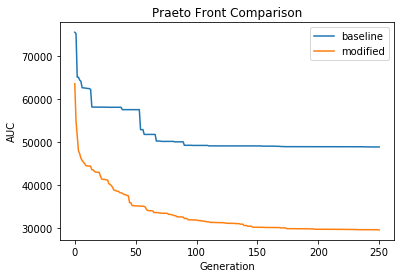

In [12]:
gen = logbook.select("gen")
plt.plot(gen, hof.aucs, label="baseline")
plt.plot(gen, hof2.aucs, label="modified")
plt.legend(loc="upper right")
plt.xlabel("Generation")
plt.ylabel("AUC")
plt.title("Praeto Front Comparison")
plt.show()

In [13]:
test_data = np.genfromtxt(open("../data/test.csv"), delimiter=',', skip_header=1, usecols=(0, 1, 4, 5, 6, 7, 9, 11), converters={4: sex, 11: embarked})
test_ids = test_data[:, 0]
test_X = test_data[:, 1:]
fill_missing(test_X)

func = gp.compile(expr=hof2[0], pset=pset)
preds = func(*test_X.T)
output = np.stack((test_ids, preds), axis=1)
np.savetxt("gp_submission.csv", output, fmt="%i", delimiter=',', header="PassengerId,Survived", comments='')